<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
<tr>
    <td width=30% style="border:none">
        <center>
            <img src="../images/iapau_icon.png" width="30%"/><br>
            <a href="https://iapau.org/">Association IA Pau</a><br>
            <a href="https://iapau.org/events/festival/">Festival IAPau 7</a>
        </center>
    </td>
    <td style="border:none">
        <center>
            <h1>Atelier - Agentic RAG</h1>
            <h2>The Mastermind</h2>
            <h2>Orchestration du moteur de raisonnement</h2>
        </center>
    </td>
    <td width=20% style="border:none">
    </td>
</tr>
</table>

---

**Prérequis :** Compléter d'abord les Phases 0, 1 et 2.

Dans ce notebook, nous allons construire le graphe pour orchestrer notre agent IA.

---

## 📋 Table des matières

1. [**Gestion des états**](#define-the-master-graph-and-enhanced-state)
   - `AgentState` TypedDict 
   - Chargement des outils construits dans de la Phase 2

2. [**Nœud `Gatekeeper` : Détection d'ambiguïté**](#gatekeeper-node)
   - Analyse de spécificité des requêtes
   - Génération de questions de clarification

3. [**Nœud `Planner` : Cerveau du superviseur**](#planner-node)
   - Création de plans étape par étape
   - Sélection intelligente des outils

4. [**Nœud `Executor` : Le travailleur**](#tool-executor-node)
   - Exécution des étapes du plan
   - Gestion des résultats intermédiaires

5. [**Nœud `Auditor` : Auto-correction cognitive**](#auditor-node)
   - Vérification de la qualité des sorties
   - Système de scores de confiance

6. [**Routeur conditionnel avancé : Système nerveux**](#routeur)
   - Logique de navigation complexe
   - Gestion des boucles de rétroaction

7. [**Nœud `Strategist` : Synthétiseur avec inférence causale**](#strategist-node)
   - Génération d'insights et connexions
   - Analyse causale des données

8. [**Compilation et exécution du graphe**](#compile-and-run-graph)
   - Assemblage final du moteur de raisonnement
   - Tests et démonstrations

---


In [1]:
import os
import json
from typing import List, Dict, Any, Optional, TypedDict
from rich import print as rprint
from rich.pretty import Pretty
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END

<a id="define-the-master-graph-and-enhanced-state"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>1. Gestion des états </div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Nous allons définir la structure de notre agent, c'est-à-dire sont état. La classe <i>AgentState</i> va nous permettre de suivre les différents résultats de notre agents, de la vérification et les questions de clarification potentielles, du suivi du plan et jusqu'au résultat final.</strong></p>
  </div>
</div>

In [2]:
class AgentState(TypedDict):
    """Defines the state of our agent graph."""
    original_request: str
    clarification_question: Optional[str] # For ambiguity handling
    plan: List[str]
    intermediate_steps: List[Dict[str, Any]]
    verification_history: List[Dict[str, Any]] # For self-correction
    final_response: str

print("AgentState TypedDict defined.")

AgentState TypedDict defined.


In [3]:
# Charger les outils de la phase 2
from specialist_tools import librarian_rag_tool, analyst_sql_tool, analyst_trend_tool, tools, tool_map

tools = [librarian_rag_tool, analyst_sql_tool, analyst_trend_tool]
tool_map = {tool.name: tool for tool in tools}

print("\n=== Available Tools ===")
for tool in tools:
    print(f"\n- Tool: {tool.name}")
    print(f"  Description: {tool.description.strip()}")

✓ Specialist tools loaded successfully!
  Available tools: ['librarian_rag_tool', 'analyst_sql_tool', 'analyst_trend_tool']

=== Available Tools ===

- Tool: librarian_rag_tool
  Description: Expert at finding information from NVIDIA's financial documents.
Use for questions about financial performance, business segments, products, risks, strategies.

- Tool: analyst_sql_tool
  Description: Expert financial analyst that queries NVIDIA's revenue and net income database.
Use for questions about specific financial numbers for a single time period.
For trends over time, use the analyst_trend_tool.

- Tool: analyst_trend_tool
  Description: Analyzes financial data over multiple time periods to identify trends and growth rates.
Best for questions like 'Analyze revenue trend' or 'Show me growth YoY'.
Provides narrative summary of trends, not just raw numbers.


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion de la sortie</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Notre <i>AgentState</i> est maintenant créé, avec des champs dédiés pour <code>clarification_question</code> et <code>verification_history</code>. Cela permettra au graphe de suivre explicitement ces étapes cognitives.</p>
  </div>
</div>

<a id="gatekeeper-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>2. `Gatekeeper` Node - Détection d'ambiguïté</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Il s'agit de notre premier nœud dans le graphe. Avant toute planification, nous allons transmettre la demande de l'utilisateur à un « <i>Gatekeeper</i> ».</p> 
    <p style='margin:0 0 8px 0;color:#000;'>Le rôle du <i>Gatekeeper</i> est de déterminer si la requête est suffisamment spécifique à notre cas d'usage. Si elle est trop vague (par exemple, « Comment va l'entreprise ? »), il générera une question de clarification et arrêtera le processus. Cela empêche l'agent de produire une réponse générique de faible valeur.</strong></p>
  </div>
</div>

In [4]:
ambiguity_llm = ChatOpenAI(model='gpt-4o', api_key=os.environ.get('OPENAI_API_KEY'), temperature=0.)

def ambiguity_check_node(state: AgentState) -> Dict[str, Any]:
    """Checks if the user's request is ambiguous and requires clarification."""
    print("\n-- Gatekeeper (Ambiguity Check) Node --")
    request = state['original_request']
    
    prompt = f"""You are an expert at identifying ambiguity. Given the user's request, is it specific enough to be answered with high precision using financial data?
    - A specific request asks for a number, a date, a named risk, or a comparison (e.g., 'What was revenue in Q4 2023?').
    - An ambiguous request is open-ended (e.g., 'How is NVIDIA doing?', 'What's the outlook?').

    If the request is ambiguous, formulate a single, polite question to the user that would provide the necessary clarification. Otherwise, respond with just 'OK'.

    User Request: "{request}"
    
    Response:
    """
    
    response = ambiguity_llm.invoke(prompt).content
    
    if response.strip() == "OK":
        print("  - Request is specific. Proceeding to planner.")
        return {"clarification_question": None}
    else:
        print(f"  - Request is ambiguous. Generating clarification question.")
        return {"clarification_question": response}

In [5]:
# --- Test the Gatekeeper ---
ambiguous_state = ambiguity_check_node({"original_request": "How is NVIDIA doing?"})
print(f"    Case 1: Ambiguous Query ('How is NVIDIA doing?')\n  - Result: {ambiguous_state}")

specific_state = ambiguity_check_node({"original_request": "What was the NVIDIA revenue trend over the last 2 years?"})
print(f"    Case 2: Specific Query ('What was the NVIDIA revenue trend over the last 2 years?')\n  - Result: {specific_state}")


-- Gatekeeper (Ambiguity Check) Node --
  - Request is ambiguous. Generating clarification question.
    Case 1: Ambiguous Query ('How is NVIDIA doing?')
  - Result: {'clarification_question': "Could you please specify what aspect of NVIDIA's performance you are interested in, such as financial metrics, stock performance, or market position?"}

-- Gatekeeper (Ambiguity Check) Node --
  - Request is specific. Proceeding to planner.
    Case 2: Specific Query ('What was the NVIDIA revenue trend over the last 2 years?')
  - Result: {'clarification_question': None}


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion de la sortie</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le résultat des tests démontrent l'utilité de la mise en place du <i>Gatekeeper</i>. Il peut identifier correctement la requête vague et génère une question de clarification utile et spécifique. Pour la requête claire, il la laisse passer sans interférence. Ce nœud simple augmente considérablement la précision et l'utilité de l'ensemble du système en s'assurant qu'il ne travaille que sur des problèmes bien définis et à valeur ajouté, une caractéristique clé du comportement humain.</p>
  </div>
</div>

<a id="planner-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>3. `Planner` Node</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le <i>Planner</i> est notre cerveau. Il prend la requête utilisateur (maintenant vérifiée comme étant spécifique) et, en se basant sur les descriptions des outils disponibles, crée un plan étape par étape pour y répondre.</strong></p>
  </div>
</div>

In [7]:
supervisor_llm = ChatOpenAI(model='gpt-4.1', api_key=os.environ.get('OPENAI_API_KEY'), temperature=0.)

def create_planner_prompt(tools):
    tool_descriptions = "\n".join([f"- {tool.name}: {tool.description.strip()}" for tool in tools])
    
    return f"""You are a master financial analyst agent, the Supervisor. Your task is to create a step-by-step plan to answer the user's request by intelligently selecting from the available tools.
        
        **Available Tools:**
        {tool_descriptions}

        **Instructions:**
        1. Analyze the user's request.
        2. Create a clear, step-by-step plan. Each step must be a call to one of the available tools.
        3. The final step in your plan should ALWAYS be 'FINISH'.
        
        **Output Format:**
        Return the plan as a Python-parseable list of strings. For example: ["analyst_trend_tool('analyze revenue')", "FINISH"]
        ---
        
        User Request: {{request}}
        
        Plan:
    """

planner_prompt_template = create_planner_prompt(tools)

def planner_node(state: AgentState) -> Dict[str, Any]:
    print("\n-- Planner Node --")
    request = state['original_request']
    prompt = planner_prompt_template.format(request=request)
    plan_str = supervisor_llm.invoke(prompt).content
    try:
        plan = eval(plan_str)
        print(f"  - Generated Plan:\n {plan}")
        return {"plan": plan}
    except Exception as e:
        print(f"Error parsing plan: {e}. Falling back to FINISH.")
        return {"plan": ["FINISH"]}

In [8]:
# --- Test the Planner Node ---
test_planner_state = {
    "original_request": "Analyze NVIDIA's revenue trend over the last two years and find related competitive risks in the 10-K."}
planner_output = planner_node(test_planner_state)
print(f"\nPlanner Output for State:")
rprint(Pretty(planner_output))


-- Planner Node --
  - Generated Plan:
 ["analyst_trend_tool('analyze NVIDIA revenue trend over the last two years')", "librarian_rag_tool('find competitive risks related to revenue in NVIDIA’s latest 10-K')", 'FINISH']

Planner Output for State:


{
    'plan': [
        "analyst_trend_tool('analyze NVIDIA revenue trend over the last two years')",
        "librarian_rag_tool('find competitive risks related to revenue in NVIDIA’s latest 10-K')",
        'FINISH'
    ]
}

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le planificateur exploite correctement notre équipe de spécialistes ! </p>
    <p style='margin:0 0 8px 0;color:#000;'>Pour une requête nécessitant à la fois une analyse de tendances et une récupération de documents, il crée un plan parfait. Il sait utiliser l'<code>analyst_trend_tool</code> spécialisé pour l'analyse de séries temporelles et le <code>librarian_rag_tool</code> pour les informations qualitatives sur les risques.</p> 
    <p style='margin:0 0 8px 0;color:#000;'>Cela démontre que les descriptions claires des outils permettent au <i>Planner</i> de déléguer les tâches correctement.</p>
  </div>
</div>

<a id="tool-executor-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>4. `Tool Executor` Node</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Ce nœud est le travailleur du système (i.e. <i>Executor</i>). Il prend le plan, exécute la prochaine étape en utilisant l'outil approprié, et ajoute le résultat à <code>intermediate_steps</code>.</strong></p>
  </div>
</div>

In [9]:
def tool_executor_node(state: AgentState) -> Dict[str, Any]:
    print("\n-- Tool Executor Node --")
    next_step = state['plan'][0]
    try:
        tool_name = next_step.split('(')[0]
        tool_input_str = next_step[len(tool_name)+1:-1]
        tool_input = eval(tool_input_str)
    except Exception as e:
        print(f"  - Error parsing tool call: {e}. Skipping step.")
        return {"plan": state['plan'][1:], "intermediate_steps": state.get('intermediate_steps', [])}

    print(f"  - Executing tool: {tool_name} with input: '{tool_input}'")
    tool_to_call = tool_map[tool_name]
    result = tool_to_call.invoke(tool_input)
    
    new_intermediate_step = {
        'tool_name': tool_name,
        'tool_input': tool_input,
        'tool_output': result
    }
    
    current_steps = state.get('intermediate_steps', [])
    return {
        "intermediate_steps": current_steps + [new_intermediate_step],
        "plan": state['plan'][1:]
    }

In [12]:
# --- Test the Executor Node ---
test_executor_state = {
    'plan': ["analyst_trend_tool('Analyze revenue trend')", "FINISH"],
    'intermediate_steps': []
}
executor_output = tool_executor_node(test_executor_state)

print("\n--- Executor Output for State ---")
print(f"Remaining Plan: {executor_output['plan']}")
print(f"Intermediate Steps: {json.dumps(executor_output['intermediate_steps'], indent=2)}")


-- Tool Executor Node --
  - Executing tool: analyst_trend_tool with input: 'Analyze revenue trend'

-- Analyst Trend Tool Called with query: 'Analyze revenue trend' --

--- Executor Output for State ---
Remaining Plan: ['FINISH']
Intermediate Steps: [
  {
    "tool_name": "analyst_trend_tool",
    "tool_input": "Analyze revenue trend",
    "tool_output": "\n    Analysis of revenue_usd_billions from 2020-Q1 to 2024-Q4:\n    - The series shows a general upward trend, starting at $3.11B and ending at $35.08B.\n    - The most recent quarter (2024-Q4) had a Quarter-over-Quarter growth of 16.8%.\n    - The Year-over-Year growth for the most recent quarter was 93.6%.\n    - Overall, performance indicates consistent growth over the analyzed period.\n    "
  }
]


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le test démontre que notre <code>analyst_trend_tool</code> peut être appelé comme n'importe quel autre outil. L'exécuteur a lancé l'outil avec succès, capturé sa sortie narrative et l'a ajoutée à l'état. Le plan a été mis à jour correctement, montrant que le système est prêt pour la prochaine étape de son processus de raisonnement.</p>
  </div>
</div>

<a id="auditor-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>5. `Auditor` Node - Auto-correction cognitive</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Après l'exécution d'un outil, sa sortie est transmise à ce nœud <i>Auditor</i>. L'<i>Auditor</i> agit comme un <strong>second avis</strong> critique. Il évalue la sortie de l'outil par rapport à la demande originale pour vérifier la pertinence et la cohérence. Si la sortie est de faible qualité, le système peut être redirigé vers le <i>Planner</i> pour essayer une approche différente. Cela construit une couche d'<strong>auto-correction</strong> dans la boucle de raisonnement de l'agent.</strong></p>
    <p style='margin:0 0 8px 0;color:#000;'>Il s'agit d'une amélioration cognitive majeure. </p>
  </div>
</div>

In [13]:
class VerificationResult(BaseModel):
    """Structured output for the Auditor node."""
    confidence_score: int = Field(description="Score from 1-5 on confidence in the tool's output.")
    is_consistent: bool = Field(description="Is the output internally consistent?")
    is_relevant: bool = Field(description="Is the output relevant to the original user request?")
    reasoning: str = Field(description="Brief reasoning for the scores.")

auditor_llm = ChatOpenAI(
    model='gpt-4o', api_key=os.environ.get('OPENAI_API_KEY'), temperature=0.).with_structured_output(VerificationResult)

def verification_node(state: AgentState) -> Dict[str, Any]:
    """Audits the most recent tool output for quality and relevance."""
    print("\n-- Auditor (Self-Correction) Node --")
    request = state['original_request']
    last_step = state['intermediate_steps'][-1]
    
    prompt = f"""You are a meticulous fact-checker and auditor. Given the user's original request and the output from a tool, please audit the output.
    
    **User Request:** {request}
    **Tool:** {last_step['tool_name']}
    **Tool Output:** {json.dumps(last_step['tool_output'])}
    
    **Audit Checklist:**
    1.  **Relevance:** Is this output directly relevant to answering the user's request? (Score 1-5, where 5 is highly relevant).
    2.  **Consistency:** Is the data internally consistent? (e.g., no contradictory statements).
    
    Based on this, provide a confidence score and a brief reasoning.
    """
    
    audit_result = auditor_llm.invoke(prompt)
    print(f"  - Audit Confidence Score: {audit_result.confidence_score}/5")
    
    current_history = state.get('verification_history', [])
    # Il suffit de renvoyer l'historique de vérification, le routeur se chargera du reste.
    return {"verification_history": current_history + [audit_result.model_dump()]}

In [14]:
# --- Test Auditor ---
print("--- Testing Auditor Node ---")
test_auditor_state = {
    'original_request': 'Analyze the revenue trend over the last two years',
    'intermediate_steps': executor_output['intermediate_steps'] # Utiliser les résultats du test précédent
}
auditor_output = verification_node(test_auditor_state)
print("\nTest Result:")
print(json.dumps(auditor_output['verification_history'][0], indent=2))

--- Testing Auditor Node ---

-- Auditor (Self-Correction) Node --
  - Audit Confidence Score: 3/5

Test Result:
{
  "confidence_score": 3,
  "is_consistent": true,
  "is_relevant": false,
  "reasoning": "1. **Relevance:**\n   - The user's request was to analyze the revenue trend over the last two years. However, the tool's output provides an analysis from 2020-Q1 to 2024-Q4, which spans a period of nearly five years. This is broader than the user's specified timeframe of two years. \n   - The output does mention the most recent quarter's growth, which could be relevant, but it does not focus specifically on the last two years as requested. \n   - **Relevance Score:** 3 (The output contains some relevant information but does not directly address the user's request for a two-year analysis.)\n\n2. **Consistency:**\n   - The tool's output is internally consistent, providing a clear upward trend in revenue with specific figures for the starting and ending points, as well as growth percenta

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>L'<i>Auditor</i> a évalué avec succès la sortie de l'outil <code>analyst_trend_tool</code>. Il a attribué un score de confiance et confirmé que l'information est à la fois cohérente et pertinente. Cette étape de vérification structurée est cruciale pour construire la confiance. Si un outil devait retourner des données incohérentes, ce nœud le signalerait avec un score de confiance faible, permettant à notre routeur (dans l'étape suivante) de prendre des mesures correctives, comme replanifier la tâche. Cela rend l'ensemble du système plus robuste et fiable.</p>
  </div>
</div>

<a id="routeur"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>6. Routeur conditionnel</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Nous avons maintenant besoin d'un routeur conditionnel qui peut gérer le flux de notre moteur de raisonnement. Ce routeur inspectera l'état après chaque étape et décidera où aller ensuite basé sur une hiérarchie de conditions :</p>
    <p style='margin:0 8px 0 0;font-weight:600;color:#000;'></p>
    <ul style='margin:8px 0 0 18px;color:#000;'>
      <li><strong>Une question de clarification a-t-elle été générée ?</strong>  (Ceci est vérifié au début). Si oui, s'arrêter et demander à l'utilisateur.</li>
      <li><strong>La dernière vérification a-t-elle échoué</strong>  (ex., score de confiance < 3) ? Si oui, revenir au Planificateur pour essayer une nouvelle approche.</li>
      <li><strong>Le plan est-il terminé ?</strong>  Si oui, procéder au Synthétiseur (i.e. <i>Strategist</i>).</li>
      <li><strong>Sinon</strong> , revenir à l'exécuteur d'outils (i.e. <i>Executor</i>) pour continuer le plan.</li>
    </ul>
  </div>
</div>

In [15]:
def router_node(state: AgentState, min_score: int=3) -> str:
    """This node decides the next step in the graph based on the current state."""
    print("\n-- Advanced Router Node --")

    # Check for clarification first, this is a terminal state
    if state.get("clarification_question"):
        print("  - Decision: Ambiguity detected. Halting to ask user.")
        return END

    # Check if we need to start the main workflow
    if not state.get("plan"):
        print("  - Decision: New request. Routing to planner.")
        return "planner"

    # Check the last verification result if it exists
    if state.get("verification_history"):
        last_verification = state["verification_history"][-1]
        if last_verification["confidence_score"] < min_score:
            print("  - Decision: Verification failed. Returning to planner.")
            # Clear the plan to force replanning
            state['plan'] = [] 
            return "planner"

    # Check if the plan is complete
    if not state.get("plan") or state["plan"][0] == "FINISH":
        print("  - Decision: Plan is complete. Routing to synthesizer.")
        return "synthesize"
    else:
        print("  - Decision: Plan has more steps. Routing to tool executor.")
        return "execute_tool"

In [16]:
# --- Test the Router Logic ---
print("Test Case 1: Ambiguity detected")
print(f"  - Result: {router_node({'clarification_question': 'Please clarify.'})}")

print("\nTest Case 2: Verification Failed")
print(f"  - Result: {router_node({'verification_history': [{'confidence_score': 2}]})}")

print("\nTest Case 3: Plan has more steps")
print(f"  - Result: {router_node({'plan': ['step 1', 'FINISH'], 'verification_history': [{'confidence_score': 5}]})}")

print("\nTest Case 4: Plan is finished")
print(f"  - Result: {router_node({'plan': ['FINISH'], 'verification_history': [{'confidence_score': 5}]})}")

Test Case 1: Ambiguity detected

-- Advanced Router Node --
  - Decision: Ambiguity detected. Halting to ask user.
  - Result: __end__

Test Case 2: Verification Failed

-- Advanced Router Node --
  - Decision: New request. Routing to planner.
  - Result: planner

Test Case 3: Plan has more steps

-- Advanced Router Node --
  - Decision: Plan has more steps. Routing to tool executor.
  - Result: execute_tool

Test Case 4: Plan is finished

-- Advanced Router Node --
  - Decision: Plan is complete. Routing to synthesizer.
  - Result: synthesize


<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Les cas de test confirment la logique de notre routeur. Il gère correctement tous les états clés de notre moteur de raisonnement : s'arrêter pour demander des clarifications à l'utilisateur, revenir au planificateur en cas d'échec de vérification, continuer le plan quand tout se passe bien, et finalement passer à la synthèse lorsque le travail est terminé. </p>
    <p style='margin:0 0 8px 0;color:#000;'>Ce routeur est le <strong>système nerveux</strong> de notre agent.</p>
  </div>
</div>

<a id="strategist-node"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>7. `Strategist` Node - Synthétiseur avec inférence causale</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Il s'agit de la note finale de notre agent. Le Synthétiseur (i.e. <i>Strategist</i>) ne se contentera pas de résumer les données collectées. Nous définissons son prompt pour l'instruire d'agir comme un stratège: il doit essayer de <strong>faire le lien</strong> entre les différentes informations recueillies par les outils. S'il voit une tendance financière de l'<i>Analyst</i> et un risque lié du <i>Librerian</i>, il devrait générer une hypothèse sur un lien causal potentiel. Cela fait passer l'agent du rapport de faits à la génération de perspectives (avec perspicacité).</p>
  </div>
</div>

In [17]:
synthesizer_llm = ChatOpenAI(model='gpt-4o', api_key=os.getenv('OPENAI_API_KEY'), temperature=0.2)

def synthesizer_node(state: AgentState) -> Dict[str, Any]:
    print("\n-- Strategist (Synthesizer) Node --")
    request = state['original_request']
    context = "\n\n".join([f"## Tool: {step['tool_name']}\nInput: {step['tool_input']}\nOutput: {json.dumps(step['tool_output'], indent=2)}" for step in state['intermediate_steps']])

    prompt = f"""You are an expert financial analyst acting as a strategist. Your task is to synthesize a comprehensive answer 
    to the user's request based on the context provided by your specialist agents, generating novel insights where possible.

    **User Request:**
    {request}

    **Context from Agents:**
    ---
    {context}
    ---

    **Instructions:**
    1.  Carefully review the context from the tool outputs.
    2.  Construct a clear, well-written, and accurate answer to the user's original request.
    3.  **Connect the Dots (Causal Inference):** After summarizing the findings, analyze the combined information. Is there a plausible causal link or correlation between different pieces of data (e.g., a risk mentioned by the Librarian and a financial trend from the Analyst)?
    4.  **Frame as Hypothesis:** Clearly state this connection as a data-grounded hypothesis, using phrases like 'The data suggests a possible link...' or 'One potential hypothesis is...'. This is your key value-add.

    Final Answer:
    """
    
    final_answer = synthesizer_llm.invoke(prompt).content
    print("  - Generated final answer with causal inference.")
    return {"final_response": final_answer}

In [18]:
# --- Test the Synthesizer Node ---
# Use the executor output from the previous test
test_synth_state = {
    'original_request': "Analyze the revenue trend from 2022 to 2024 and connect it to any major AI-related risks.",
    'intermediate_steps': [
        executor_output['intermediate_steps'][0],  # Use the trend tool output from executor test
        {'tool_name': 'librarian_rag_tool', 'tool_input': 'AI risks', 'tool_output': [
            {'source': '10-K/0001045810-25-000023', 'content': 'Competition in the AI field is rapidly evolving...',
             'summary': 'This section highlights the intensifying competition in the rapidly evolving field of Artificial Intelligence (AI) as a key risk.'}
        ]}
    ]
}
synth_output = synthesizer_node(test_synth_state)

# Display formatted output
print("\n" + "="*40)
print("SYNTHESIZER FINAL RESPONSE")
print("="*40)
from IPython.display import display, Markdown
display(Markdown(synth_output['final_response']))


-- Strategist (Synthesizer) Node --
  - Generated final answer with causal inference.

SYNTHESIZER FINAL RESPONSE


Based on the analysis of the revenue trend from 2022 to 2024, there is a clear upward trajectory in revenue, starting at $3.11 billion and reaching $35.08 billion by the end of 2024. The most recent quarter (2024-Q4) showed a significant Quarter-over-Quarter growth of 16.8% and an impressive Year-over-Year growth of 93.6%. This indicates a period of consistent and robust growth over the analyzed timeframe.

In parallel, the context provided by the librarian highlights a key risk in the field of Artificial Intelligence: the rapidly evolving and intensifying competition. This competitive landscape is a critical factor that companies in the AI sector must navigate.

**Connecting the Dots (Causal Inference):**

The data suggests a possible link between the revenue growth trend and the competitive dynamics in the AI field. One potential hypothesis is that the significant revenue growth observed from 2022 to 2024 could be partially driven by the company's ability to effectively compete and innovate in the AI space. As competition intensifies, companies that can leverage AI to enhance their products and services may capture greater market share, thus driving revenue growth.

However, this competitive environment also poses risks. Companies must continuously invest in research and development to maintain their competitive edge, which could impact profit margins if not managed efficiently. Additionally, the rapid pace of AI advancements means that companies face the risk of technological obsolescence if they fail to keep up with industry leaders.

In summary, while the revenue trend from 2022 to 2024 is positive, the underlying AI-related risks highlight the importance of strategic investments in innovation and competitive positioning to sustain this growth trajectory.

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>L'agent ne se contente pas de lister la tendance des revenus et le risque lié à l'IA côte à côte. Il les connecte activement, formant une hypothèse raisonnable et fondée sur les données: que la chose même qui stimule la croissance (l'investissement dans l'IA) est également une source majeure de risque. C'est une forme d'insight qui imite la pensée critique d'un analyste humain. La capacité à générer de telles connexions est ce qui élève véritablement l'agent d'un simple outil à un moteur de raisonnement.</p>
  </div>
</div>

<a id="compile-and-run-graph"></a>
### <b><div style='padding:15px;background-color:#4A5568;color:white;border-radius:2px;font-size:110%;text-align: left'>8. Compilation et exécution du graphe</div></b>

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0f7ff,#ffffff);padding:16px;border-left:6px solid #2b6cb0;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>🚀</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Ce que nous allons faire</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Il est temps d'assembler tous nos nœuds dans le graphe de raisonnement complet. Le flux est maintenant finalisé, intégrant le <i>Gatekeeper</i>, l'<i>Executor</i>, l'<i>Auditor</i>, le <i>Strategist</i> et plusieurs boucles de rétroaction.</p>
  </div>
</div>

Graph compiled successfully!


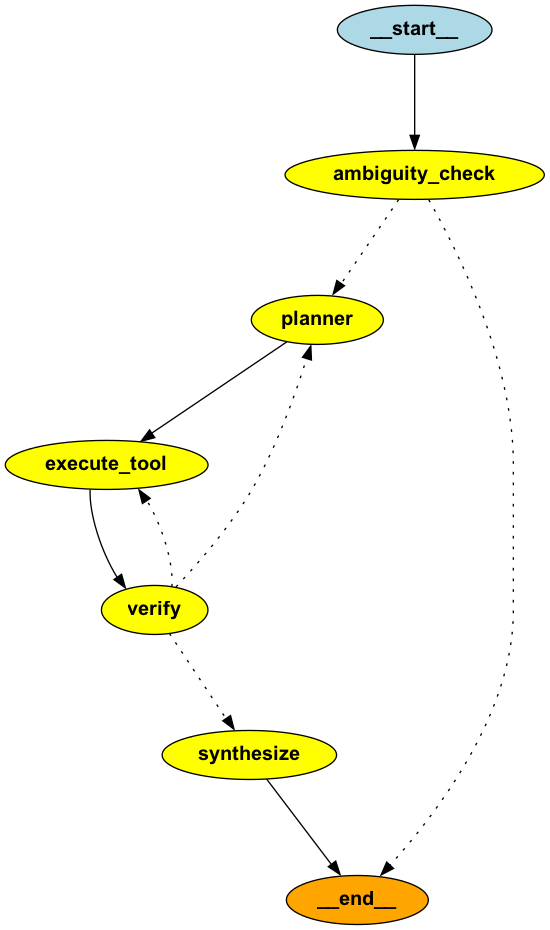

In [19]:
graph_builder = StateGraph(AgentState)

# Ajouter des nœuds au graphe
graph_builder.add_node("ambiguity_check", ambiguity_check_node)
graph_builder.add_node("planner", planner_node)
graph_builder.add_node("execute_tool", tool_executor_node)
graph_builder.add_node("verify", verification_node)
graph_builder.add_node("synthesize", synthesizer_node)

# Définir le point d'entrée
graph_builder.set_entry_point("ambiguity_check")

# Définir la connexion conditionnelle à partir du vérificateur d'ambiguïté
graph_builder.add_conditional_edges(
    "ambiguity_check",
    lambda state: "planner" if state.get("clarification_question") is None else END,
    {"planner": "planner", END: END}
)

# Après la planification, exécutez toujours un outil.
graph_builder.add_edge("planner", "execute_tool")

# Après l'exécution, vérifiez toujours
graph_builder.add_edge("execute_tool", "verify")

# Le ROUTEUR CONDITIONNEL relie l'étape de vérification au nœud logique suivant.
graph_builder.add_conditional_edges(
    "verify",
    router_node,
    {
        "planner": "planner",
        "execute_tool": "execute_tool",
        "synthesize": "synthesize",
    }
)

# Le synthétiseur est un nœud terminal
graph_builder.add_edge("synthesize", END)

# Compiler le graphique
app = graph_builder.compile()

print("Graph compiled successfully!")
try:
    from IPython.display import Image, display
    # Créer et afficher le graphique
    png_image = app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"Could not visualize graph: {e}")

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion des résultats</h2>
    <p style='margin:0 0 8px 0;color:#000;'>Le graphe est maintenant compilé et prêt à être utilisé.</p> 
    <p style='margin:0 0 8px 0;color:#000;'>La visualisation montre notre boucle de raisonnement. Vous pouvez suivre le chemin depuis la vérification d'ambiguïté initiale, en passant par le planificateur, jusqu'à la boucle principale <strong>execute_tool -> verify -> router</strong>.</p> 
    <p style='margin:0 0 8px 0;color:#000;'>Les arêtes conditionnelles du routeur montrent la boucle de rétroaction vers le planificateur (pour l'auto-correction) ou l'exécuteur (pour continuer le plan), ainsi que le chemin final vers le synthétiseur. Cette carte visuelle rend la logique de notre agent claire et compréhensible.</p>
  </div>
</div>

In [20]:
from IPython.display import display, Markdown, HTML

def run_app(query: str):
    """Un wrapper pour exécuter le graphe et imprimer le résultat final de manière claire."""
    print("\n" + "="*40)
    print("🚀 RUNNING APP")
    print("="*40)
    print(f"📝 Query: {query}")
    print("="*40 + "\n")
    
    # Ensure initial state has empty lists for accumulation
    inputs = {"original_request": query, "verification_history": [], "intermediate_steps": []}
    final_state = {}
    
    # Use a for loop to stream and see the flow, but capture the last state for the final answer
    for output in app.stream(inputs, stream_mode="values"):
        final_state.update(output)
    
    print("\n" + "="*40)
    if final_state.get('clarification_question'):
        print("❓ CLARIFICATION NEEDED")
        print("="*40)
        display(Markdown(final_state['clarification_question']))
    else:
        print("✅ FINAL SYNTHESIZED RESPONSE")
        print("="*40 + "\n")
        display(Markdown(final_state['final_response']))
    
    return final_state

In [21]:
# Exécuter avec une requête ambiguë# 
print("\n" + "🔍 TEST 1: AMBIGUOUS QUERY" + "\n")
ambiguous_run_state = run_app("Tell me about Nvidia's performance.")


🔍 TEST 1: AMBIGUOUS QUERY


🚀 RUNNING APP
📝 Query: Tell me about Nvidia's performance.


-- Gatekeeper (Ambiguity Check) Node --
  - Request is ambiguous. Generating clarification question.

❓ CLARIFICATION NEEDED


How would you like Nvidia's performance to be measured? For example, are you interested in financial metrics like revenue or profit, stock performance, or another specific aspect?

In [22]:
# Exécutez une requête complexe et spécifique.
print("🔍 TEST 2: COMPLEX SPECIFIC QUERY" + "\n")
complex_run_state = run_app("Analyze Nvidia's revenue trend from 2022 to 2024 by Quarter.")

🔍 TEST 2: COMPLEX SPECIFIC QUERY


🚀 RUNNING APP
📝 Query: Analyze Nvidia's revenue trend from 2022 to 2024 by Quarter.


-- Gatekeeper (Ambiguity Check) Node --
  - Request is specific. Proceeding to planner.

-- Planner Node --
  - Generated Plan:
 ["analyst_trend_tool('Analyze Nvidia revenue trend by quarter from 2022 to 2024')", 'FINISH']

-- Tool Executor Node --
  - Executing tool: analyst_trend_tool with input: 'Analyze Nvidia revenue trend by quarter from 2022 to 2024'

-- Analyst Trend Tool Called with query: 'Analyze Nvidia revenue trend by quarter from 2022 to 2024' --

-- Auditor (Self-Correction) Node --
  - Audit Confidence Score: 4/5

-- Advanced Router Node --
  - Decision: Plan is complete. Routing to synthesizer.

-- Strategist (Synthesizer) Node --
  - Generated final answer with causal inference.

✅ FINAL SYNTHESIZED RESPONSE



Based on the analysis of Nvidia's revenue trend from 2022 to 2024 by quarter, we observe a robust and consistent upward trajectory in their financial performance. Starting from 2020-Q1 with a revenue of $3.11 billion, Nvidia's revenue has grown significantly, reaching $35.08 billion by 2024-Q4. The most recent quarter (2024-Q4) demonstrated a strong Quarter-over-Quarter growth of 16.8% and an impressive Year-over-Year growth of 93.6%.

This consistent growth pattern over the analyzed period suggests that Nvidia has been effectively capitalizing on its market opportunities, likely driven by increased demand for its products in sectors such as gaming, data centers, and AI technologies. The substantial Year-over-Year growth indicates that Nvidia is not only maintaining its market position but also expanding its reach and influence in the tech industry.

**Causal Inference and Hypothesis:**

The data suggests a possible link between Nvidia's revenue growth and the broader adoption of AI and machine learning technologies, which require high-performance computing solutions that Nvidia provides. One potential hypothesis is that the increasing integration of AI across various industries has significantly contributed to Nvidia's revenue surge. This trend is likely supported by Nvidia's strategic investments in AI research and development, as well as its partnerships with leading tech companies to deliver cutting-edge solutions. As AI continues to permeate different sectors, Nvidia's revenue is expected to maintain its upward trend, driven by sustained demand for its advanced computing capabilities.

In [25]:
# Exécutez une requête complexe et spécifique.
print("🔍 TEST 3: COMPLEX SPECIFIC QUERY" + "\n")
complex_run_state = run_app("Analyze Nvidia's revenue trend from 2022 to 2024 by Quarter and discuss how it might relate to the risks mentioned in their SEC reports.")


🔍 TEST 3: COMPLEX SPECIFIC QUERY


🚀 RUNNING APP
📝 Query: Analyze Nvidia's revenue trend from 2022 to 2024 by Quarter and discuss how it might relate to the risks mentioned in their SEC reports.


-- Gatekeeper (Ambiguity Check) Node --
  - Request is specific. Proceeding to planner.

-- Planner Node --
  - Generated Plan:
 ["analyst_trend_tool('Analyze Nvidia revenue trend by quarter from 2022 to 2024')", "librarian_rag_tool('Summarize key risks mentioned in Nvidia SEC reports from 2022 to 2024, especially those that could impact revenue')", 'FINISH']

-- Tool Executor Node --
  - Executing tool: analyst_trend_tool with input: 'Analyze Nvidia revenue trend by quarter from 2022 to 2024'

-- Analyst Trend Tool Called with query: 'Analyze Nvidia revenue trend by quarter from 2022 to 2024' --

-- Auditor (Self-Correction) Node --
  - Audit Confidence Score: 3/5

-- Advanced Router Node --
  - Decision: Plan has more steps. Routing to tool executor.

-- Tool Executor Node --
  - Executing 

Based on the analysis of Nvidia's revenue trend from 2022 to 2024 and the risks outlined in their SEC reports, we can draw several insights and potential connections.

### Revenue Trend Analysis
From 2022 to 2024, Nvidia's revenue has shown a robust upward trajectory. Starting at $3.11 billion, it reached $35.08 billion by the end of 2024. The most recent quarter (2024-Q4) exhibited a significant quarter-over-quarter growth of 16.8% and an impressive year-over-year growth of 93.6%. This consistent growth pattern highlights Nvidia's strong market position and the increasing demand for its products, particularly in areas like data center compute and AI solutions.

### Key Risks from SEC Reports
1. **Supply Chain and Demand Estimation Risks:** Nvidia faces challenges related to long manufacturing lead times and uncertain supply and component availability. Inaccurate demand estimation has previously led to mismatches between supply and demand, resulting in product shortages or excess inventory, which could adversely affect financial results.

2. **Business Investments and Acquisitions:** The company also faces risks associated with integrating acquired businesses, which could impact its ability to grow, develop new products, or sell existing products effectively.

### Connecting the Dots: Causal Inference
The data suggests a possible link between Nvidia's revenue growth and the risks identified in their SEC reports. One potential hypothesis is that Nvidia's strong revenue growth is partly driven by its strategic focus on high-demand areas like AI and data center solutions, which are less susceptible to immediate supply chain disruptions due to their specialized nature. However, the risks associated with supply chain management and demand estimation inaccuracies could pose significant threats to sustaining this growth. If Nvidia fails to accurately predict demand or manage its supply chain effectively, it could lead to financial volatility, impacting future revenue trends.

Additionally, while business acquisitions have the potential to enhance Nvidia's growth and product offerings, the challenges in integrating these acquisitions could hinder the company's ability to capitalize on new opportunities, thereby affecting revenue growth.

In summary, while Nvidia's revenue trend is positive, the underlying risks related to supply chain management and business integration could influence future performance. Addressing these risks effectively will be crucial for maintaining the growth trajectory observed from 2022 to 2024.

<div style='display:flex;align-items:center;gap:16px;background:linear-gradient(90deg,#f0fff4,#ffffff);padding:16px;border-left:6px solid #16a34a;border-radius:8px;'>
  <div style='width:5%;min-width:64px;text-align:center;font-size:44px;line-height:1;'>✅</div>
  <div style='width:90%;color:#000;'>
    <h2 style='margin:0 0 6px 0;color:#000;font-size:1.15em;'>Discussion de la sortie</h2>
    <p style='margin:0 0 8px 0;color:#000;'>C'est l'aboutissement de notre agent. La sortie démontre toute la puissance de ces capacités de raisonnement.</p>
    <p style='margin:0 8px 0 0;font-weight:600;color:#000;'></p>
    <ul style='margin:8px 0 0 18px;color:#000;'>
      <li><strong>Gestion de l'ambiguïté</strong> : La première exécution montre le `Gatekeeper` en action. Face à une requête vague, l'agent s'arrête correctement et demande des précisions, économisant du calcul et offrant une meilleure expérience utilisateur.</li><br>
      <li><strong>Boucle cognitive</strong> : La deuxième exécution met en valeur toute la boucle cognitive. Nous voyons le `Gatekeeper` approuver la requête, le Planificateur créer un plan en plusieurs étapes utilisant le nouvel `analyst_trend_tool`, l'Exécuteur et l'Auditeur travailler en tandem pour chaque étape, et le Routeur guider correctement le flux.</li><br>
      <li><strong>Synthèse perspicace</strong> : La réponse finale est la partie la plus impressionnante. Elle ne se contente pas d'énumérer des faits. Elle synthétise l'analyse de tendance et les informations sur les risques en une hypothèse cohérente et perspicace. Le type d'analyse à valeur ajoutée que vous attendriez d'un analyste humain qualifié. Cette exécution réussie valide toute notre architecture.</li>
    </ul>
    <br>
    <p style='margin:0 0 8px 0;color:#000;'>Cooment évaluer notre Agent IA ?</p>
  </div>
</div>